# Developing Causal Impact analysis with Deep Learning models

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../src')

In [3]:
from parse_cesar1 import get_timestep_tuples
import pickle

In [119]:
from pyprocessta.causalimpact import _select_unrelated_x
from pyprocessta.model.tcn import transform_data, run_model
from pyprocessta.model.backtesting import historical_forecasts

In [5]:
from darts import TimeSeries
import pandas as pd
from definitions import TARGETS
import matplotlib.pyplot as plt

MEAS_COLUMNS = [
    "TI-19",
    "FI-16",
    "TI-33",
    "FI-2",
    "FI-151",
    "TI-8",
    "FI-241",
    "valve-position-12",  # dry-bed
    "FI-38",  # stripper
    "PI-28",  # stripper
    "TI-28",  # stripper
    "FI-20",
    "FI-30",
    "TI-3",
    "FI-19",
    "FI-211",
    "FI-11",
    "TI-30",
    "PI-30",
    "TI-1213",
    "TI-4",
    "FI-23",
    "delta_t",
]

In [6]:
df = pd.read_pickle('detrended.pkl')
df = df.dropna()
df['delta_t'] = df['TI-35'] - df["TI-4"]
MEAS_COLUMNS.append('delta_t')

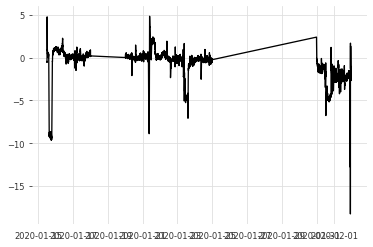

In [7]:
plt.plot(df['delta_t'])

In [8]:
with open('step_times.pkl', 'rb') as handle:
    times = pickle.load(handle)

In [11]:
def get_causalimpact_splits(x, y, day, times, df): 
    a, b = get_timestep_tuples(df, times, day)
 
    x_way_before, x_after = x.split_before(a[1])
    y_way_before, y_after = y.split_before(pd.Timestamp(a[1]))

    _, x_before = x_way_before.split_before(a[0])
    _, y_before = y_way_before.split_before(a[0])

    x_during, x_test = x_after.split_before(b[1])
    y_during, y_test = y_after.split_before(b[1])

    return (x_before, y_before), (x_during, y_during), (x_test, y_test)

    
    

In [12]:
y = TimeSeries.from_dataframe(df, value_cols=TARGETS)
x = TimeSeries.from_dataframe(df, value_cols=MEAS_COLUMNS)

In [147]:
causalimpact_models = {}

for day in range(10):

    before, during, after = get_causalimpact_splits(x, y, day, times, df)
    train_tuple, test_tuple, scalers = transform_data(before, [during, after])
    model = run_model(train_tuple)

    causalimpact_models[day] = {
        'before': before, 
        'during': during,
        'after': after, 
        'model': model
    }


(129, 24) (129, 4)
(12407, 24) (12407, 4)


[2021-04-19 17:20:18,042] INFO | darts.models.torch_forecasting_model | Train dataset contains 64 samples.
[2021-04-19 17:20:18,042] INFO | darts.models.torch_forecasting_model | Train dataset contains 64 samples.


(119, 24) (119, 4)
(11847, 24) (11847, 4)


[2021-04-19 17:21:41,958] INFO | darts.models.torch_forecasting_model | Train dataset contains 430 samples.
[2021-04-19 17:21:41,958] INFO | darts.models.torch_forecasting_model | Train dataset contains 430 samples.


(149, 24) (149, 4)
(11104, 24) (11104, 4)


[2021-04-19 17:24:12,773] INFO | darts.models.torch_forecasting_model | Train dataset contains 583 samples.
[2021-04-19 17:24:12,773] INFO | darts.models.torch_forecasting_model | Train dataset contains 583 samples.


(149, 24) (149, 4)
(8947, 24) (8947, 4)


[2021-04-19 17:27:25,682] INFO | darts.models.torch_forecasting_model | Train dataset contains 1997 samples.
[2021-04-19 17:27:25,682] INFO | darts.models.torch_forecasting_model | Train dataset contains 1997 samples.


(154, 24) (154, 4)
(8137, 24) (8137, 4)


[2021-04-19 17:34:33,467] INFO | darts.models.torch_forecasting_model | Train dataset contains 645 samples.
[2021-04-19 17:34:33,467] INFO | darts.models.torch_forecasting_model | Train dataset contains 645 samples.


(154, 24) (154, 4)
(7497, 24) (7497, 4)


[2021-04-19 17:37:18,610] INFO | darts.models.torch_forecasting_model | Train dataset contains 475 samples.
[2021-04-19 17:37:18,610] INFO | darts.models.torch_forecasting_model | Train dataset contains 475 samples.


(154, 24) (154, 4)
(6772, 24) (6772, 4)


[2021-04-19 17:39:58,483] INFO | darts.models.torch_forecasting_model | Train dataset contains 560 samples.
[2021-04-19 17:39:58,483] INFO | darts.models.torch_forecasting_model | Train dataset contains 560 samples.


(154, 24) (154, 4)
(6074, 24) (6074, 4)


[2021-04-19 17:43:00,318] INFO | darts.models.torch_forecasting_model | Train dataset contains 533 samples.
[2021-04-19 17:43:00,318] INFO | darts.models.torch_forecasting_model | Train dataset contains 533 samples.


[2021-04-19 17:45:32,349] ERROR | darts.timeseries | ValueError: Timestamp must be between 2020-01-15 11:42:01 and 2020-01-24 12:36:01


ValueError: Timestamp must be between 2020-01-15 11:42:01 and 2020-01-24 12:36:01

In [150]:
for day, values in causalimpact_models.items():
    before_predictions = []
    during_predictions = []
    after_predictions = []

    for i in range(200):
        x_test, y_test = values['before']
        before_predictions.append(model.historical_forecasts(y_test,
                                                covariates=x_test,
                                                start=0.2,
                                                forecast_horizon=1,
                                                stride=1,
                                                retrain=False,
                                                verbose=False))
        
        x_test, y_test = values['during']
        during_predictions.append(model.historical_forecasts(y_test,
                                                covariates=x_test,
                                                start=0.2,
                                                forecast_horizon=1,
                                                stride=1,
                                                retrain=False,
                                                verbose=False))

        x_test, y_test = values['after']
        after_predictions.append(model.historical_forecasts(y_test,
                                                covariates=x_test,
                                                start=0.2,
                                                forecast_horizon=1,
                                                stride=1,
                                                retrain=False,
                                                verbose=False))

    causalimpact_models[day]['before_predictions'] = before_predictions
    causalimpact_models[day]['during_predictions'] = during_predictions
    causalimpact_models[day]['after_predictions'] = after_predictions
        

In [ ]:
with open('causalimpact.pkl', 'wb') as handle: 
    pickle.dump(causalimpact_models, handle)

In [ ]:
test

In [145]:
x_test, y_test = test_tuple[1]  
backtest_cov = model.historical_forecasts(y_test,
                                                covariates=x_test,
                                                start=0.1,
                                                forecast_horizon=1,
                                                stride=1,
                                                retrain=False,
                                                verbose=False)

0.2, inplace=False)
Dropout(p=0.2, inplace=False)
Dropout(p=0.2, inplace=False)
Dropout(p=0.2, inplace=False)
Dropout(p=0.2, inplace=False)
Dropout(p=0.2, inplace=False)
Dropout(p=0.2, inplace=False)
Dropout(p=0.2, inplace=False)
Dropout(p=0.2, inplace=False)
Dropout(p=0.2, inplace=False)
Dropout(p=0.2, inplace=False)
Dropout(p=0.2, inplace=False)
Dropout(p=0.2, inplace=False)
Dropout(p=0.2, inplace=False)
Dropout(p=0.2, inplace=False)
Dropout(p=0.2, inplace=False)
Dropout(p=0.2, inplace=False)
Dropout(p=0.2, inplace=False)
Dropout(p=0.2, inplace=False)
Dropout(p=0.2, inplace=False)
Dropout(p=0.2, inplace=False)
Dropout(p=0.2, inplace=False)
Dropout(p=0.2, inplace=False)
Dropout(p=0.2, inplace=False)
Dropout(p=0.2, inplace=False)
Dropout(p=0.2, inplace=False)
Dropout(p=0.2, inplace=False)
Dropout(p=0.2, inplace=False)
Dropout(p=0.2, inplace=False)
Dropout(p=0.2, inplace=False)
Dropout(p=0.2, inplace=False)
Dropout(p=0.2, inplace=False)
Dropout(p=0.2, inplace=False)
Dropout(p=0.2, inpla

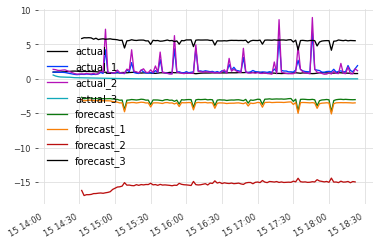

In [100]:
y_test.plot(label='actual')
backtest_cov.plot(label='forecast')
plt.legend()